# Exploring Modeled Flammability by Fire Management Zone

This notebook demonstrates how to query the SNAP Data API for both fire management zone polygons and modeled flammability within those polygons. In this example, we use ARDAC helper functions from the ```ardac_utils.py``` module to quickly fetch and summarize these datasets.

### Setup:
Import python packages and all functions from the ```ardac_utils.py``` module.

In [17]:
from ardac_utils import *
import matplotlib.pyplot as plt
from matplotlib import colors as mpl_colors

### Fetch polygons using the SNAP Data API

Use the ```get_area_gdf_by_category()``` helper function to fetch fire zone GeoJSON polygons from the SNAP Data API and convert them to a geodataframe object. 

The category string that we pass to this function is identical to the endpoint URL found in the [documentation](https://earthmaps.io/boundary/) for the physical and administrative boundary datasets. For example, if one would use ```earthmaps.io/places/fire_zones``` to get fire management zone data, we can pass the last part of this URL (```"fire_zones"```) as input to the helper function. By also passing the EPSG code ```3338``` to the function, we can automatically convert the geodataframe from the native WGS84 geographic system (EPSG 4326) to the Alaska Albers projected coordinate system (EPSG 3338).

In [2]:
fz_gdf = get_area_gdf_by_category("fire_zones", 3338)
print(fz_gdf)

       id                     name  \
0   FIRE1    Anchorage/Mat-Su Area   
0   FIRE2  Chugach National Forest   
0   FIRE3        Copper River Area   
0   FIRE4               Delta Area   
0   FIRE5           Fairbanks Area   
0   FIRE6              Galena Zone   
0   FIRE7              Haines Area   
0   FIRE8        Kenai/Kodiak Area   
0   FIRE9            Military Zone   
0  FIRE10           Southwest Area   
0  FIRE11              Tanana Zone   
0  FIRE12                 Tok Area   
0  FIRE13  Tongass National Forest   
0  FIRE14         Upper Yukon Zone   

                                            the_geom  
0  MULTIPOLYGON (((179735.363 1260498.039, 179648...  
0  MULTIPOLYGON (((432390.403 1071064.869, 432427...  
0  MULTIPOLYGON (((395901.999 1262963.191, 395898...  
0  MULTIPOLYGON (((402950.393 1577683.072, 403767...  
0  MULTIPOLYGON (((469798.746 1666798.327, 468840...  
0  MULTIPOLYGON (((-741020.270 1539327.852, -7411...  
0  MULTIPOLYGON (((1035301.513 1180928.372, 

View the polygons projected in Alaska Albers.

<Axes: >

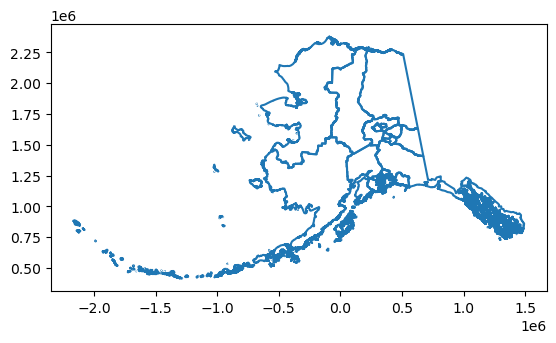

In [3]:
fz_gdf.boundary.plot()

### Fetch data and summarize by polygon

Use the ```get_data_for_gdf_polygons()``` helper function to fetch modeled flammability data from the SNAP Data API and summarize by polygon. We pass the polygon geodataframe to the function, as well as a dataset name string, and the function will return a dataframe. If data is not available for a specific polygon, the function will return an error message to that effect.

Currently, the datasets offering zonal statistics are climate indicators (```'indicators'```), climate protection from spruce bark beetles ```('beetles')```, modeled flammability (```'flammability'```), modeled vegetation type(```'veg_type'```), and modeled air temperature and precipitation (```'temperature'```, ```'precipitation'```, or combined ```'temperature_and_precipitation'```). See the function documentation for details on accepted arguments.

In [4]:
fz_data = get_data_for_gdf_polygons(fz_gdf, "flammability")
print(fz_data)

Bad request, no flammability data for FIRE10: Southwest Area...trying next polygon...
        id                   name date_range         model    scenario    mean
0    FIRE1  Anchorage/Mat-Su Area  1950-1979  MODEL-SPINUP  historical  0.0003
1    FIRE1  Anchorage/Mat-Su Area  1980-2008  MODEL-SPINUP  historical  0.0004
2    FIRE1  Anchorage/Mat-Su Area  2010-2039     5modelAvg       rcp45  0.0027
3    FIRE1  Anchorage/Mat-Su Area  2010-2039     5modelAvg       rcp60  0.0008
4    FIRE1  Anchorage/Mat-Su Area  2010-2039     5modelAvg       rcp85  0.0011
..     ...                    ...        ...           ...         ...     ...
51  FIRE14       Upper Yukon Zone  2070-2099     MRI-CGCM3       rcp60  0.0040
52  FIRE14       Upper Yukon Zone  2070-2099     MRI-CGCM3       rcp85  0.0027
53  FIRE14       Upper Yukon Zone  2070-2099    NCAR-CCSM4       rcp45  0.0051
54  FIRE14       Upper Yukon Zone  2070-2099    NCAR-CCSM4       rcp60  0.0061
55  FIRE14       Upper Yukon Zone  2070-2099 

### Subset the data and analyze:

Subset the dataset to include just the flammability values from the historical model spin-up and the projected 5-model average for emissions scenario RCP 8.5. We can see there are two date ranges (1950-1979, 1980-2008) for the historical spin-up and three different date ranges (2010-2039, 2030-2069, and 2070-2099) for the projected model/scenario combination.

In [5]:
#fz_data_subset = fz_data[(fz_data['model'] == '5modelAvg') & (fz_data['scenario'] == 'rcp85')]
fz_data_subset = fz_data[((fz_data['model'] == '5modelAvg') |
                        (fz_data['model'] == 'MODEL-SPINUP')) &
                        ((fz_data['scenario'] == 'rcp85') | 
                        (fz_data['scenario'] == 'historical'))].reset_index()


print(fz_data_subset)

    index      id                   name date_range         model    scenario  \
0       0   FIRE1  Anchorage/Mat-Su Area  1950-1979  MODEL-SPINUP  historical   
1       1   FIRE1  Anchorage/Mat-Su Area  1980-2008  MODEL-SPINUP  historical   
2       4   FIRE1  Anchorage/Mat-Su Area  2010-2039     5modelAvg       rcp85   
3      22   FIRE1  Anchorage/Mat-Su Area  2040-2069     5modelAvg       rcp85   
4      40   FIRE1  Anchorage/Mat-Su Area  2070-2099     5modelAvg       rcp85   
..    ...     ...                    ...        ...           ...         ...   
60      0  FIRE14       Upper Yukon Zone  1950-1979  MODEL-SPINUP  historical   
61      1  FIRE14       Upper Yukon Zone  1980-2008  MODEL-SPINUP  historical   
62      4  FIRE14       Upper Yukon Zone  2010-2039     5modelAvg       rcp85   
63     22  FIRE14       Upper Yukon Zone  2040-2069     5modelAvg       rcp85   
64     40  FIRE14       Upper Yukon Zone  2070-2099     5modelAvg       rcp85   

      mean  
0   0.0003  
1

Using the 1980-2008 period as a historical baseline, let's compute the projected percentage increase or decrease in flammability for each projected date range.

We accomplish this by:

 - Normalizing the flammability values to range between 1 and 2. (The raw data values are small decimals, and since we are interested in relative changes we are free to rescale these values.) Since its not possible to calculate a percent change from 0, our scale will start at 1.

 - Building a dictionary of historical flammability values, using fire management zone IDs as keys and mean flammability as values.

 - Adding a new column (```pct_change```) to our dataframe. By iterating through each row in the subset and calculating the percentage for projected years, we can populate the value in the new column for that row. 

 - Finally, since the rows with historical date ranges will not have any ```pct_change``` value, we can simply drop any rows with NA values to remove these from the subset.

In [6]:
#normalize 0-1
fz_data_subset['f_norm'] = (fz_data_subset['mean'] - fz_data_subset['mean'].min()) / (fz_data_subset['mean'].max() - fz_data_subset['mean'].min())
#add 1 to normalized values, so we are normalized 1-2
fz_data_subset['f_norm'] = fz_data_subset['f_norm'] + 1

In [7]:
historical_flam = {}

for index, row in fz_data_subset.iterrows():
    if row['date_range'] == '1980-2008':
        historical_flam[row['id']] = row['f_norm']

historical_flam

{'FIRE1': 1.0404040404040404,
 'FIRE2': 1.0,
 'FIRE3': 1.404040404040404,
 'FIRE4': 1.9494949494949494,
 'FIRE5': 1.9797979797979797,
 'FIRE6': 1.2727272727272727,
 'FIRE7': 1.0,
 'FIRE8': 1.2121212121212122,
 'FIRE9': 2.0,
 'FIRE11': 1.101010101010101,
 'FIRE12': 1.797979797979798,
 'FIRE13': 1.0,
 'FIRE14': 1.6767676767676767}

In [8]:
fz_data_subset['pct_change'] = None
projected_years = ['2010-2039', '2040-2069', '2070-2099']

for index, row, in fz_data_subset.iterrows():
    if row['date_range'] in projected_years:
        fz_data_subset.loc[index, 'pct_change'] = ((historical_flam[row['id']] - row['f_norm']) / historical_flam[row['id']]) * 100

fz_data_subset.dropna(inplace=True)
print(fz_data_subset)

    index      id                     name date_range      model scenario  \
2       4   FIRE1    Anchorage/Mat-Su Area  2010-2039  5modelAvg    rcp85   
3      22   FIRE1    Anchorage/Mat-Su Area  2040-2069  5modelAvg    rcp85   
4      40   FIRE1    Anchorage/Mat-Su Area  2070-2099  5modelAvg    rcp85   
7       4   FIRE2  Chugach National Forest  2010-2039  5modelAvg    rcp85   
8      22   FIRE2  Chugach National Forest  2040-2069  5modelAvg    rcp85   
9      40   FIRE2  Chugach National Forest  2070-2099  5modelAvg    rcp85   
12      4   FIRE3        Copper River Area  2010-2039  5modelAvg    rcp85   
13     22   FIRE3        Copper River Area  2040-2069  5modelAvg    rcp85   
14     40   FIRE3        Copper River Area  2070-2099  5modelAvg    rcp85   
17      4   FIRE4               Delta Area  2010-2039  5modelAvg    rcp85   
18     22   FIRE4               Delta Area  2040-2069  5modelAvg    rcp85   
19     40   FIRE4               Delta Area  2070-2099  5modelAvg    rcp85   

Now use the fire zone ID to join the subset table to the fire management zone polygons in order to plot the values on a map.

In [9]:
plot_gdf = fz_gdf.merge(fz_data_subset, how='left', on='id')

Plot the percentage change in flammability for each fire management zone, using a different map for each date range. 

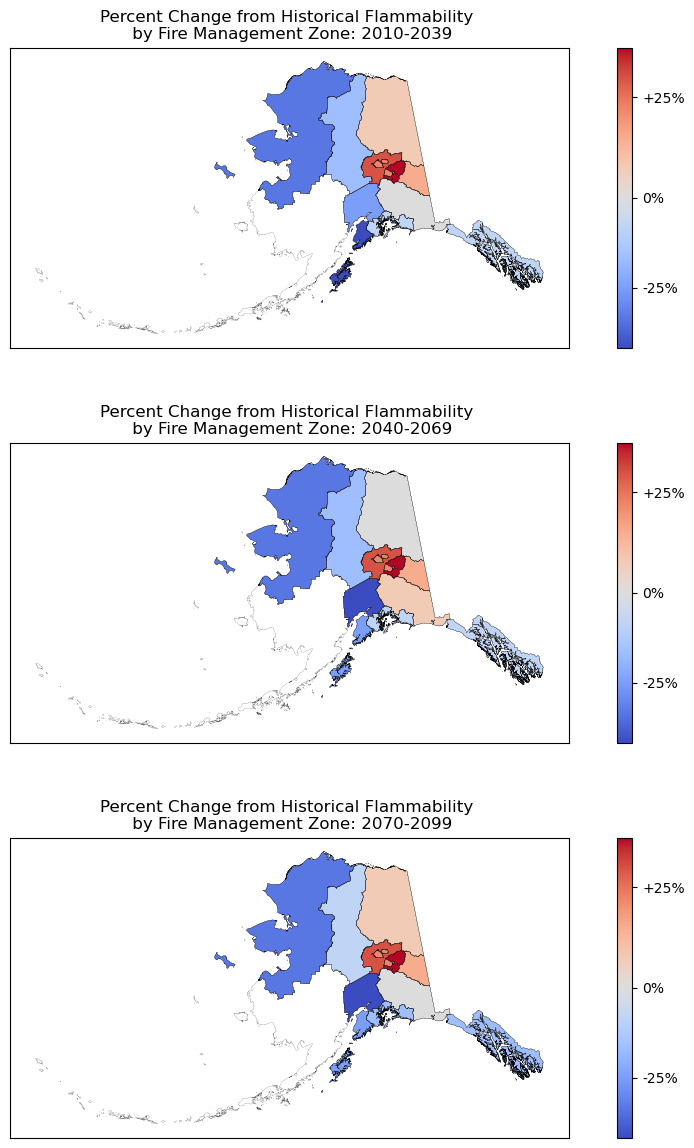

In [21]:
#arrange subplots
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,12))
#create a color normalization centered on 0, and using the % change min/max 
cmap_norm = mpl_colors.TwoSlopeNorm(vmin=plot_gdf['pct_change'].min(), vcenter=0, vmax=plot_gdf['pct_change'].max())

#plot the 3 date ranges on their own subplots (ax1, ax2, and ax3)
#ax1 = 2010-2039
plot_gdf.boundary.plot(color='black', linewidth=0.1, ax=ax1)
plot_gdf[plot_gdf['date_range'] == '2010-2039'].plot(column='pct_change', cmap='coolwarm', ax=ax1)
#ax2 = 2040-2069
plot_gdf.boundary.plot(color='black', linewidth=0.1, ax=ax2)
plot_gdf[plot_gdf['date_range'] == '2040-2069'].plot(column='pct_change', cmap='coolwarm', ax=ax2)
#ax3 = 2070-2099
plot_gdf.boundary.plot(color='black', linewidth=0.1, ax=ax3)
plot_gdf[plot_gdf['date_range'] == '2070-2099'].plot(column='pct_change', cmap='coolwarm', ax=ax3)

#create colorbars for each subplot using the custom color normalization and setting +/- 25% as tick marks
#ax1 colorbar
colorbar_ax1 = fig.colorbar(mappable=None, norm=cmap_norm, cmap='coolwarm', ax=ax1, location="right", ticks=[-25, 0, 25])
colorbar_ax1.set_ticklabels(['-25%', '0%', '+25%'], fontsize=10)
#ax2 colorbar
colorbar_ax2 = fig.colorbar(mappable=None, norm=cmap_norm, cmap='coolwarm', ax=ax2, location="right", ticks=[-25, 0, 25])
colorbar_ax2.set_ticklabels(['-25%', '0%', '+25%'], fontsize=10)
#ax3 colorbar
colorbar_ax3 = fig.colorbar(mappable=None, norm=cmap_norm, cmap='coolwarm', ax=ax3, location="right", ticks=[-25, 0, 25])
colorbar_ax3.set_ticklabels(['-25%', '0%', '+25%'], fontsize=10)

#set titles for each subplot
ax1.title.set_text('Percent Change from Historical Flammability \n by Fire Management Zone: 2010-2039')
ax2.title.set_text('Percent Change from Historical Flammability \n by Fire Management Zone: 2040-2069')
ax3.title.set_text('Percent Change from Historical Flammability \n by Fire Management Zone: 2070-2099')

#remove x and y axis coordinate labels
fig.tight_layout()
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax3.axes.get_xaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)

